### ECE 1505 Convex Optimization Project
-David Islip

-Gurjot Dhaliwal

In [440]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cvxpy as cp
import matplotlib.cm as cm
from datetime import datetime
import scipy.linalg as la
import yfinance as yf
from sklearn.metrics.pairwise import euclidean_distances
import pickle as pkl
sns.set_style('whitegrid')
%matplotlib inline

Run the code below to get tickers from wikipedia

    table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    df = table[0]
    df.to_csv('S&P500-Info.csv')
    df.to_csv("S&P500-Symbols.csv", columns=['Symbol'])
    
The next bit of code using the iex api to get historical info for the current S&P 500 stocks. (The same approach adopted in Boyd)

Our period of analysis is will be start January 2012 to end of March 2020

In [441]:
sp = pd.read_csv('S&P500-Symbols.csv', index_col=[0])

### I tried using the iex data provider, however they limit to a 5 year history. Code is below

    from iexfinance.stocks import Stock
    from iexfinance.stocks import get_historical_data

    API_TOKEN = '''
    def getHistoricalPrices(stock):
        return get_historical_data(stock, start, end, 
                                   output_format='pandas', 
                                   token=API_TOKEN)

This code extracts the data from yahoo finance

    data = yf.download(sp.values[:,0].tolist(), start="2012-01-01", end="2020-03-31")
    data.to_pickle("stocks.pkl")

In [442]:
#use the adjusted closing prices for the analysis
data = pd.read_pickle("stocks.pkl")
data['Adj Close'].head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,23.818647,4.826837,67.798805,50.994907,NaN,33.385769,18.250000,21.986044,44.309837,28.570000,...,26.864021,64.519592,33.558529,18.584305,22.358345,34.445507,50.152138,35.720001,15.257210,NaN
2012-01-04,23.629299,4.741990,69.388268,51.268970,NaN,33.499771,18.110001,21.900763,44.293118,28.280001,...,26.582462,64.534569,33.549038,18.470987,23.096504,34.680763,49.473404,35.450001,15.593829,NaN
2012-01-05,24.158173,5.156795,69.829826,51.838169,NaN,33.754089,18.270000,21.850374,43.447910,28.480000,...,26.814333,64.339516,33.577511,18.357662,22.767448,34.945400,50.059166,35.400002,16.030531,NaN
2012-01-06,24.419334,5.279352,70.153603,52.380054,NaN,33.841782,18.139999,21.652693,43.372604,28.719999,...,26.640434,63.859360,33.378315,18.357662,22.385023,35.198296,50.189331,35.110001,16.048729,NaN
2012-01-09,25.059198,5.392481,70.133995,52.296970,NaN,33.824242,18.209999,21.648811,43.297291,28.530001,...,27.220114,64.144455,33.217072,18.335001,22.473965,35.063023,50.561256,34.950001,16.267075,NaN


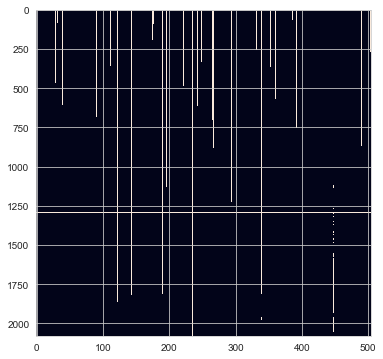

In [443]:
#### Investigate Missing Values
plt.figure(figsize = (6,6))
plt.imshow(data['Adj Close'].isna().astype(int),aspect='auto');

### Boyd's Paper drops the series that do not contain continuous observations

paper ctrl-f 'S&P' for details https://stanford.edu/~boyd/papers/pdf/cvx_portfolio.pdf 

In [444]:
P = data['Adj Close']
P = P[~P.isna().all(axis=1)] #dropping rows with all missing values
P = P.loc[:,~P.isna().any(axis=0)]
P.head()

,A,AAL,AAP,AAPL,ABC,ABMD,ABT,ACN,ADBE,ADI,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,23.818647,4.826837,67.798805,50.994907,33.385769,18.250000,21.986044,44.309837,28.570000,29.164673,...,20.369633,26.864021,64.519592,33.558529,18.584305,22.358345,34.445507,50.152138,35.720001,15.257210
2012-01-04,23.629299,4.741990,69.388268,51.268970,33.499771,18.110001,21.900763,44.293118,28.280001,29.124205,...,20.235518,26.582462,64.534569,33.549038,18.470987,23.096504,34.680763,49.473404,35.450001,15.593829
2012-01-05,24.158173,5.156795,69.829826,51.838169,33.754089,18.270000,21.850374,43.447910,28.480000,29.253723,...,20.324926,26.814333,64.339516,33.577511,18.357662,22.767448,34.945400,50.059166,35.400002,16.030531
2012-01-06,24.419334,5.279352,70.153603,52.380054,33.841782,18.139999,21.652693,43.372604,28.719999,29.059444,...,20.265320,26.640434,63.859360,33.378315,18.357662,22.385023,35.198296,50.189331,35.110001,16.048729
2012-01-09,25.059198,5.392481,70.133995,52.296970,33.824242,18.209999,21.648811,43.297291,28.530001,29.626060,...,20.280226,27.220114,64.144455,33.217072,18.335001,22.473965,35.063023,50.561256,34.950001,16.267075


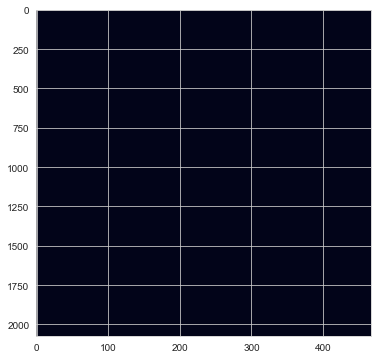

In [445]:
#### No more missing values
plt.figure(figsize = (6,6))
plt.imshow(P.isna().astype(int),aspect='auto');

### We will follow the same conventions in the paper 'Detecting change points in VIX and S&P 500: A new approach to dynamic asset allocation' by Nystrup et. al 

$r_t = (P_t - P_{t-1})/P_{t-1}$

In [446]:
#returns
R = P.pct_change().dropna(axis=0)

# Changepoint detection:

Given a series, a window to define the changepoint, use the wasserstein hypothesis estimator to detect the change

If there is a change then we will reoptimize the portfolio, with an ambiguity parameter that is proportional to the size of the estimated change? 

### Change point detection and hypothesis testing

The paper titled "Robust Sequential Change-Point Detection by Convex Optimization" - Cao et. al frames change point detection as testing ... to be continued

The above method does not work . . . because you cannot really tell if there is a difference. Gao et. al propose the formulation and solution of the following optimization problem as way to mitigate these issues. This entire cell is taken from Gao et. al . The formulation is outlined below:

### Optimal Detectors
$\phi : \Omega \rightarrow \mathbb{R}$ associated with a test $T : \Omega \rightarrow \{1, 2\}$ (for hypothesis 1 and 2). For $\omega \in \Omega$ (a sample), the worst case risk the max of the type 1 and type 2 errors
\begin{equation}
\underset{\phi: \Omega \rightarrow \mathbb{R}}\inf \max(\underset{P_1 \in \mathcal{P_1}}\sup P_1[\omega : \phi(\omega) < 0], \ \underset{P_1 \in \mathcal{P_2}}\sup P_2[\omega : \phi(\omega) \geq  0])  , \text{(P1)}
\end{equation}

### Definition 1.
Safe Approximation of problem (3)
Risk of a detector for a test $P_1$, $P_2$, $l: \mathbb{R} \rightarrow \mathbb{R}_+ \cup \infty$

\begin{equation}
\epsilon(\phi | P_1, P_2) = \sup_{P_1 \in \mathcal{P_1}, P_2 \in \mathcal{P_2}} \mathbb{E}_{P_1}[l \circ (-\phi)(w) ] + \mathbb{E}_{P_2}[l \circ (\phi)(w) ] 
\end{equation}

\begin{equation}
\Phi(\phi ; P_1, P_2) =  \mathbb{E}_{P_1}[l \circ (-\phi)(w) ] + \mathbb{E}_{P_2}[l \circ (\phi)(w) ] 
\end{equation}

The problem below is an upper bound to P1
\begin{equation}
\underset{\phi : \Omega \rightarrow \mathbb{R}}\inf \underset{P_1 \in \mathcal{P_1}, P_2 \in \mathcal{P_2}}\sup\Phi(\phi ; P_1, P_2), \  \text{(P2)}
\end{equation}


### The problem above is near optimality of the nominal problem
Consider $\psi(p) := \underset{t\in \mathbb{R}}\min [pl(t) + (1-p)l(-t)], \ p \in [0,1]$

Then whenever there exists a solution to P1 with objective $\epsilon$ less than 0.5, then there exists a solution to P2 with objective value less than $\psi(\epsilon)$

### In P2; we can exchange the sup and inf operators
\begin{equation}
\underset{\phi : \Omega \rightarrow \mathbb{R}}\inf \underset{P_1 \in \mathcal{P_1}, P_2 \in \mathcal{P_2}}\sup\Phi(\phi ; P_1, P_2) =  \underset{P_1 \in \mathcal{P_1}, P_2 \in \mathcal{P_2}}\sup\underset{\phi : \Omega \rightarrow \mathbb{R}}\inf\Phi(\phi ; P_1, P_2)
\end{equation}

Best detector for a simple test can be found first and the least favorable distribution can be found after. This is tricky because there is no sion minmax theorem that would help (see the paper for more details)

### Theorem 2: Optimal detector

For any $P_1$ and $P_2$, let $\frac{dP_k}{d(P_1+P_2)}$ be the radon nikodym derivative of $P_k$ w.r.t $P_1+P_2$ then 

\begin{equation}
\underset{\phi : \Omega \rightarrow \mathbb{R}}\inf\Phi(\phi ; P_1, P_2) = \int_{\Omega} \psi{\big(}\frac{dP_k}{d(P_1+P_2)}{\big)} d(P_1+P_2)
\end{equation}

Let $\Omega_0(P_1, P_2) : = \{\omega \in \Omega | 0 < \frac{dP_k}{d(P_1+P_2)}(\omega) < 1, k = 1,2 \}$ and suppose 

\begin{equation}
t^{*}(\omega) = \text{argmin}_{t\in \mathbb{R}} {\big[}\frac{dP_2}{d(P_1+P_2)}l(t) + \frac{dP_1}{d(P_1+P_2)}l(-t)]  {\big ]}
\end{equation}

then $\phi(\omega) := -t^*(\omega)$

##### Remarks on Theorem 2
* $\int_{\Omega} \psi{\big(}\frac{dP_k}{d(P_1+P_2)}{\big)} d(P_1+P_2)$ is a measure of closeness (- divergence measure . . .) meaning that the worst case probability distribution in terms of optimal detection is one where the distribution is close. A major problem is now, how can one actually solve these problems given samples of data. 

### Tractable Convex Formulation

Given two empirical distributions $Q_k = \frac{1}{n_k} \sum_{i=1}^{n_k} \delta_{\bar\omega}, \ k = 1,2$
for $l = 1,...,n_1+n_2$

$$\omega^l = \begin{cases}
  \bar\omega^l, \ \ \ \  1 \leq l \leq n_1 \\
  \bar\omega^{l-n_1}, \ \ \ \  n_1+1 \leq l \leq n_1+n_2
\end{cases}$$
Set $\bar\Omega := \{ \omega^l : l = 1,...,n_1+n_2\}$

### Theorem 3
\begin{equation}
\underset{P_1 \in \mathcal{P_1}, P_2 \in \mathcal{P_2}}\sup\int_{\Omega} \psi{\big(}\frac{dP_k}{d(P_1+P_2)}{\big)} d(P_1+P_2)
\end{equation}

where $\mathcal{P_k}$ are wasserstein ambiguity sets, can be equivalently reformulated as a finite dimensional convex program

\begin{align}
\max_\underset{\normalsize{\gamma_1, \gamma_2 \in \mathbb{R}_{+}^{n_1+n_2} \times \mathbb{R}_{+}^{n_1+n_2}}}{p_1, p_2 \in \mathbb{R}_{+}^{n_1+n_2}} \quad & \sum_{l=1}^{n_1+n_2}{(p_1^l + p_2^l)\psi{\big(}  \frac{p_1^l}{p_1^l+p_2^l}{\big)}}\\
\textrm{s.t.} \quad & \sum_{l=1}^{n_1+n_2}\sum_{m=1}^{n_1+n_2} \gamma_k^{lm}||\omega^l - \omega^m || \leq \theta_k, \quad k = 1,2\\
  &\sum_{m=1}^{n_1+n_2} \gamma_1^{lm} = \frac{1}{n_1},\  1 \leq l \leq n_1, \quad  \sum_{m=1}^{n_1+n_2} \gamma_1^{lm} = 0,\  n_1 + 1 \leq l \leq n_1 + n_2 \\
  &\sum_{m=1}^{n_1+n_2} \gamma_2^{lm} = 0,\  1 \leq l \leq n_1, \quad  \sum_{m=1}^{n_1+n_2} \gamma_2^{lm} = \frac{1}{n_2},\  n_1 + 1 \leq l \leq n_1 + n_2 \\
  &\sum_{l=1}^{n_1+n_2} \gamma_k^{lm} = p_k^m, \ 1 \leq m \leq n_1+n_2,\  k = 1,2  \\
\end{align}

The table below provides the main ingredients to construct and solve the robust hypothesis testing problem. (See Table 1 in Gao et. al)

![alt text](Capture.PNG "A useful table from Gao et. al")

I emailed the authors to figure out how they actually implemented the test and they used $n_1$ and $n_2$ = 10

"we use n1 = n2 = 10 as the size of empirical samples. Fig 3(a) shows the results for a subsequence with 100 samples, and at each time t, we use n1 samples before time t and n2 samples after time t as the empirical samples for k=1,2, respectively. Then we apply the obtained optimal detector for the sample at time t; this serves as our detection statistic. The intuition is that when activity changes at time t, then we expect a significant difference between the obtained p1*(x_t) and p2*(x_t); thus we can detect the change."

In [8]:
t = len(R)-80 
n = 30
theta_val = 0.1

def robust_hypothesis(t, n, theta_val, R, rand = False):
    
    Q_1  = R.values[t-n:t,:]
    Q_2 = R.values[t+1:t+n+1,:]
    n_1 = len(Q_1)
    n_2 = len(Q_2)
    
    if rand:
        Q_1  = np.random.choice(R.values, size=n_1, replace=True, p=None)
        Q_2 = np.random.choice(R.values, size=n_2, replace=True, p=None)
    #print(len(Q_1))
    #print(len(Q_2))
    #have to modify this to make it for multi dimensional inputs
    Q = np.concatenate((Q_1, Q_2))

    A = euclidean_distances(Q, Q)
    b_1 = np.concatenate((1/n_1*np.ones(n_1), np.zeros(n_2)))
    b_2 = np.concatenate((np.zeros(n_2), 1/n_2*np.ones(n_2)))

    ## Construct the problem.
    theta = cp.Parameter()
    p1 = cp.Variable(n_1+n_2)
    p2 = cp.Variable(n_1+n_2)

    gamma_1 = cp.Variable((n_1+n_2,n_1+n_2))
    gamma_2 = cp.Variable((n_1+n_2,n_1+n_2))

    theta.value = theta_val

    constraints = [cp.sum(cp.multiply(gamma_1,A)) <= theta,
                  cp.sum(cp.multiply(gamma_2,A)) <= theta,
                  cp.sum(gamma_1, axis = 1) ==  b_1,
                  cp.sum(gamma_2, axis = 1) ==  b_2,
                  cp.sum(gamma_1, axis = 0) ==  p1,
                  cp.sum(gamma_2, axis = 0) ==  p2,
                  p1 >= 0,
                  p2 >= 0,
                  gamma_1 >= 0,
                  gamma_2 >= 0]

    #objective = cp.Minimize((p1+p2)*2*cp.minimum(p1/(p1+p2),p2/(p1+p2) ))
    objective = cp.Minimize(-2*cp.sum(cp.minimum(p1,p2)))

    prob = cp.Problem(objective,
                      constraints)
    try:
        prob.solve()
    except Exception:
        try: 
            prob.solve(verbose = False, solver=cp.SCS, max_iters=20000);
        except Exception:
            pass
    t = cp.sum(cp.multiply(gamma_1,A))
    #print(t.value)
    return [p1, p2, gamma_1, gamma_2, prob, Q]

[p1,p2, gamma_1, gamma_2, prob, Q] = robust_hypothesis(t, n, theta_val, R)

### Detection Algorithm as per the paper titled 'Robust Sequential Change-Point Detection by Convex Optimization' by Cao et. al 

$T_1 = \inf\{t > 0 | \max_{1 \leq k \leq t} \sum_{i=k}^t (-\phi(\omega^i)) \geq b\}$ this is known as the CUSUM detection method. $T$ is the first time 

From the hypothesis testing paper it also follows by the properties of the generating functions $l$ that the type one error is bounded by the expected loss function evaluated under $P_1$. That is:

$\mathbb{P_1}(\phi(\omega) <0) \leq \mathbb{E^{P_1}}[l(-\phi(\omega))]$

The formula above is only for one observation... therefore to evaluate/get a bound for the type one error for the CUSUM type detector one can follow the logic from appendix a of Cao et. al. The proof is as follows:

First note: $T = \inf \{ t > 0 | \sum_{i=1}^t -\phi(\omega^i) > b \}$ is the same procedure as $T_1$ ... therefore the arguments about $T$ hold for $T_1$

\begin{align}
  \mathbb{P}_1(T \leq m) & \leq \mathbb{P}_1 {\Big (}  \bigcup _{k=1}^m {\Big \{ } \sum_{i=1}^k -\phi(\omega^i) > b {\Big \} } {\Big )} \\
  & \leq \sum_{k=1}^m \mathbb{P}_1 {\Big (} \sum_{i=1}^k -\phi(\omega ^i) > b{\Big )} \\
  & = \sum_{k=1}^m \mathbb{P}_1 {\Big (} \sum_{i=1}^k (-\phi(\omega ^i) - \frac{b}{k} ) > 0 {\Big )}
\end{align}
Letting $\phi_k^* = \phi + \frac{b}{k}$, implies:

$$\mathbb{P_1}(-\phi_k^*(\omega) > 0 ) \leq \mathbb{E^{P_1}}[l(-\phi_k^*(\omega))]$$

Therefore in the case of $k$ repeated observations:
$$\mathbb{P}_1 {\Big (} \sum_{i=1}^k (-\phi(\omega ^i) - \frac{b}{k} ) > 0 {\Big )} \leq \mathbb{E^{P_1}}[l(-\phi_k^*(\omega))]^k$$

Then it follows that 

\begin{align}
  \mathbb{P}_1(T \leq m) & \leq   \sum_{k=1}^m {\Big (} \mathbb{E^{P_1}}[l(-\phi_k^*(\omega))]{\Big )}^k
\end{align}

Note that expressions depend on the form of the generating function. For example Goldenshluger et al use $ \phi = \log(p_1 / p_2)$ as a detector with $l(.) = \exp(.)$ and find that $\mathbb{E^{P_1}}[\exp (-\phi^*(\omega))] \leq \exp(\frac{-b}{k}) \epsilon* $ which allows Cao et. al to derive that $\mathbb{P_1}(T < \infty) = \exp(-b)*\frac{\epsilon^*}{(1-\epsilon^*)}$ and since $\mathbb{E^{P_1}}[T] \geq \frac{1}{\mathbb{P}_1(T < \infty)}$ the result follows

As discussed by Gao et. al: the detector $\phi(\omega) = \text{sign}\{p_1(\omega) - p_2(\omega)\}$ has the smallest optimality gap. Therefore, we would like to use that detector. 

#### Evaluate $\mathbb{E^{P_1}}[l(-\phi_k^*(\omega))]$ for $k = 1 \dots m$ in the case of hinge loss

\begin{align}
  \mathbb{E^{P_1}}[l(-\phi_k^*(\omega))] &= \mathbb{E^{P_1}}[(1 - \text{sign}(p_1(\omega) - p_2(\omega)) - \frac{b}{k})^+] \\
  &= \sum_{i = 1}^{n_1+n_2} p_1^i(1 - \text{sign}(p_1^i - p_2^i) - \frac{b}{k})^+ \quad \text{which implies} \sum_{k=1}^m \mathbb{P}_1 {\Big (} \mathbb{E^{P_1}}[l(-\phi_k^*(\omega))]^k{\Big )} \quad \text{is finite because}\\
 & \sum_{i = 1}^{n_1+n_2} p_1^i(1 - \text{sign}(p_1^i - p_2^i) - \frac{b}{k})^+  \leq \sum_{i = 1}^{n_1+n_2} p_1^i(1 - \text{sign}(p_1^i - p_2^i) )^+ \leq \epsilon^*
\end{align}

Although, a closed form expression for the sum $\sum_{i = 1}^{n_1+n_2} p_1^i(1 - \text{sign}(p_1^i - p_2^i) - \frac{b}{k})^+ $(and hence the ARL) is not clear, the sum can be numerically approximated with ease. Note that it is tempting to evaluate $\mu = \sum_{i = 1}^{n_1+n_2} p_1^i(1 - \text{sign}(p_1^i - p_2^i) )^+ $ and determine $\lim_{m \rightarrow \infty} \mathbb{P}_1[T < m]$ to be less than $\mu/(1-\mu)$ however, this bound is too loose to determine any average run length. If we want a fixed number of computations then we can define $M = \inf\{k | b/k < \text{tolerance}\}$ and evaluate the partial sum up to $M$ and then use the geometric approximation to provide an upper bound for the remainder.

i.e:

$$\sum_{k=1}^{\infty} {\Big (} \mathbb{E^{P_1}}[(1 - \text{sign}(p_1(\omega) - p_2(\omega)) - \frac{b}{k})^+]{\Big )}^k \leq \sum_{k=1}^M {\Big (} \mathbb{E^{P_1}}[(1 - \text{sign}(p_1(\omega) - p_2(\omega)) - \frac{b}{k})^+]{\Big )}^k + \sum_{k=M+1}^{\infty}  {\Big (} \mathbb{E^{P_1}}[(1 - \text{sign}(p_1(\omega) - p_2(\omega)))^+]{\Big )}^k $$


The sum is evaluated below $\sum_{i = 1}^{n_1+n_2} p_1^i(1 - \text{sign}(p_1^i - p_2^i) - \frac{b}{k})^+$

811518.4396710892
43


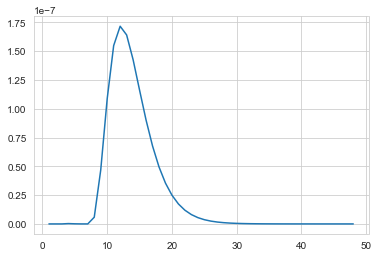

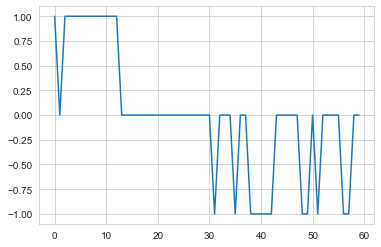

In [9]:
b = 7
signal = p1.value - p2.value
signal[np.abs(signal) < 10**(-3)*np.max(signal)] = 0
phi = np.sign(signal)

def detect_change(phi, b):
    S = np.zeros_like(phi)
    for t in range(len(phi)):
        max_sum = 0
        for k in range(t):
            if np.sum(-1*phi[k:t]) > max_sum:
                max_sum = np.sum(-1*phi[k:t])
        S[t] = max_sum
        if max_sum >= b:
            break
    return t , S
    #evaluate the max over k of the partial sum
T, S = detect_change(phi, b)

#The approach is to break the sum up into two parts 
# The first part is to up k where b/k is actually large 
# Second part takes care of the remaining infinity number 
#of terms using the geometric approximation
def calculate_ARL(p1, p2, phi, b, plots=False ):
    l = []
    sum_ = 0
    k = 1
    err = 10**(-9)

    mu = np.dot(p1.value, (np.maximum(1 - np.sign(p1.value - p2.value), 0)))
    #print(mu)
    if mu >= 1:
        M = 100000
        ARL = 0
        return ARL 
    M = np.round(np.log(err*(1-mu))/np.log(mu))
    #print(M)
    while (k <= M):
        term = np.dot(p1.value, np.maximum(1 - phi - b/k, 0))
        l.append(term**k)
        sum_ = sum_ +term**k
        k = k+1
    if plots:
        plt.plot(range(1, k), l)
    if err/sum_ > 0.01:
        print("Adjusted due to relative error")
        sum_ = sum_ + (mu**M)/(1-mu)
    ARL = 1/sum_
    return ARL

print(calculate_ARL(p1, p2, phi, b, plots = True))
plt.figure()
plt.plot(phi)
print(T)

In [12]:
#A function to make the plots
def overlap_plt(data1, data2, label1, label2, x_index, T = -1):
    fig, ax1 = plt.subplots(figsize = (12,4))

    color = 'tab:red'
    ax1.set_xlabel('index')
    ax1.set_ylabel(label1, color=color)
    ax1.plot(x_index, data1, color=color, alpha = 0.1)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel(label2, color=color)  # we already handled the x-label with ax1
    ax2.plot(x_index,data2, color=color, alpha = 0.4)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.plot([x_index[T],x_index[T]], [-1,1], 'orange')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

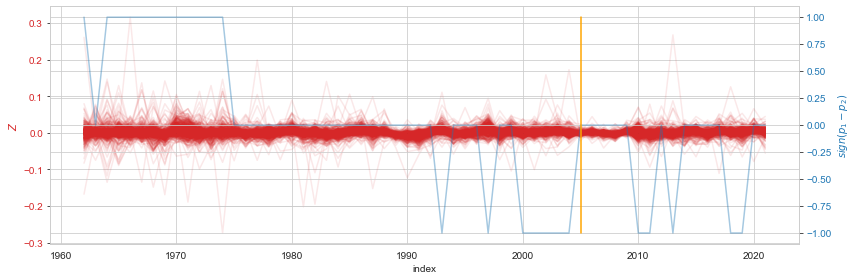

In [13]:
x_index = range(t-n,t+n)
overlap_plt(Q, phi, '$Z$', '$sign(p_1-p_2)$', x_index, T)

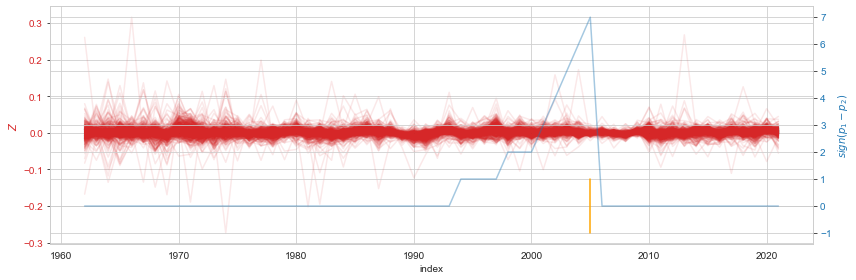

In [14]:
overlap_plt(Q, S, '$Z$', '$sign(p_1-p_2)$', x_index, T)

### Graphic of Changepoint Detection Scheme

![alt text](Capture2.PNG "A single step in the changpoint algorithm")

![alt text](Capture3.PNG "Full Changepoint Algorithm")


### Changepoint Detection Algorithm Below

In [483]:
### from the series extract a list of changepoints
times = {}
ns = [60, 90]
theta_vals = [0.05, 0.075, 0.1, 0.2, 0.5, 1]
ave_run_length = [1000, 10000]
limit = int(len(R)/30)
def get_list_of_trade_times(theta_val, ARL_target, n, limit=2*int(len(R)/n)):
    
    t_mid = n+1
    t_mids = []
    Ts = []
    ARLs = []
    balance = []
    (n1, n2) = (n,n)
    k = 0
    while t_mid <= len(R)- n2 - 1 and k < limit: #k < 2*int(len(R)/n):
        t_mids.append(t_mid)
        t_now = t_mid+n2
        #single step change point algorithm
        [p1,p2, gamma_1, gamma_2, prob, Q] = robust_hypothesis(t_mid, n, theta_val, R)
        signal = p1.value - p2.value
        signal[np.abs(signal) < 10**(-3)*np.max(signal)] = 0
        phi = np.sign(signal)
        
        for b in range(1,n):
            arl = calculate_ARL(p1, p2, phi, b, plots = False)
            if arl > ARL_target:
                break 
                
        T, S = detect_change(phi, b)
        t_mid = t_now + T - n2
        
        if T <= n1+n2: #if there was a change then store it
            balance.append(t_now)
            Ts.append(T)
            ARLs.append(arl)
            
        k = k + 1
        if k == limit:
            print("Too many rebalancing points")
            
    return {"times":balance, "mid_points": t_mids, "Ts": Ts, "ARL":ARLs}


    import itertools
    for (theta, arl_t, n) in itertools.product(theta_vals, ave_run_length, ns):
        res = get_list_of_trade_times(theta, arl_t, n, limit);
        with open(str(theta)+"_"+str(arl_t)+"_"+str(n)+".pkl", 'wb') as f:
            pkl.dump(res, f)

### The two code snippets below generate the set of rebalancing times 
    theta = 0.5
    arl_t = 1000
    n = 60
    res = get_list_of_trade_times(theta, arl_t, n);
    with open(str(theta)+"_"+str(arl_t)+"_"+str(n)+".pkl", 'wb') as f:
        pkl.dump(res, f)

    import itertools
    for (theta, arl_t, n) in itertools.product(theta_vals, ave_run_length, ns):
        res = get_list_of_trade_times(theta, arl_t, n);
        with open(str(theta)+"_"+str(arl_t)+"_"+str(n)+".pkl", 'wb') as f:
            pkl.dump(res, f)

### The code below opens one of the results and get's the rebalancing times and a-posteriori changpoints 

It also includes the capability of including a required estimation window. For example, lets say we detect at time 70 that a change occured at time 60 but we want at least 30 observations to estimate the mean and covariance ... then we would wait until time 60+30 to rebalance. If there was a detected change before time 90 then we missed the rebalancing opportunity and will try to wait again.

### post_detection_times_updated is an array of times whereby the distribution is estimated to have changed

### res_times_updated is an array of times that form the corresponding rebalancing times. 

In [574]:

def retrieve_rebalancing_info(filename, min_estimation=0):
    '''This function takes the results and extracts 
       the hypothesis model parameters and outputs
       The function takes in a minimum estimation window 
       and applies some logic to output a set of updated 
       rebalancing times that ensures the estimated quantities 
       are estimated over a window in which there are no
       detected changes'''
    with open(filename, 'rb') as f:
        res = pkl.load(f)

    [delta, arl_t, n] = [float(x) for x in filename[filename.find("/")+1:filename.find(".pkl")].split("_")]
    n = int(n)
    res_times = np.array(res['times'])
    res_times = res_times[np.array(res['ARL']) >arl_t]

    post_detections =  np.array(res['Ts'])
    post_detections = post_detections[np.array(res['ARL']) >arl_t]
    
    post_detection_times = res_times - 2*n + post_detections - 1
    if len(res['mid_points']) > 2*int(len(R)/n):
        print("Do not use this file: the hypothesis testing algorithm did not terminate")
    
    res_times_updated = np.minimum(np.maximum(res_times - post_detection_times, min_estimation) + post_detection_times, len(R)-1);
    post_detection_times_updated = post_detection_times
    i = 0
    k = 1
    leng = len(res_times)
    
    while i < leng:
        deleted = False
        for j in range(k,len(res_times)):
            if res_times_updated[i] > res_times[j]:
                res_times_updated = np.delete(res_times_updated, i)
                post_detection_times_updated = np.delete(post_detection_times_updated, i)
                deleted = True
                break
        if not deleted:
            i = i + 1
        k = k + 1
        leng = len(res_times_updated)
    return res, res_times, post_detection_times, post_detections, delta, arl_t, n, post_detection_times_updated, res_times_updated

def plot_times(R,post_detection_times, res_times):
    '''makes a plot of all the stock returns along 
    with the rebalancing times and estimation/posterior changepoint times'''
    R.plot(legend =False, alpha = 0.02, color = 'red', figsize = (12,4), ylim = (-0.5, 0.5))

    for i in post_detection_times:
        plt.axvline(x=R.index[i], color = 'orange', linewidth = 2)    

    for i in res_times:
        plt.axvline(x=R.index[i], linewidth =2)

### Follow through each of these cells to see how the estimation window update works

### Rebalancing Rules to test:

Results/0.075_10000_60.pkl:  24 rebalancing points --> rebalance every 86 days

Results/0.075_1000_60.pkl:  26 rebalancing points --> rebalance every 80 days

Results/0.075_1000_90.pkl:  12 rebalancing points --> rebalance every 173 days

Results/Results/1_10000_60.pkl:  7 rebalancing points --> rebalance every 296 days

In [662]:
filename = 'Results/1_10000_60.pkl'
estimation_window = 100;
res, res_times, post_detection_times, post_detections, delta, arl_t, n, post_detection_times_updated, res_times_updated = retrieve_rebalancing_info(filename, estimation_window)

In [663]:
len(res_times)

7

In [664]:
len(R)/len(res_times)

296.0

In [665]:
res_times_updated

array([ 219,  338,  576, 1409, 1528, 1647, 1885])

In [666]:
post_detections

array([119, 119, 119, 119, 119, 119, 119])

In [667]:
res_times - post_detection_times

array([2, 2, 2, 2, 2, 2, 2])

In [668]:
np.maximum(res_times - post_detection_times, 65)

array([65, 65, 65, 65, 65, 65, 65])

In [669]:
np.maximum(res_times - post_detection_times, 65) + post_detection_times

array([ 184,  303,  541, 1374, 1493, 1612, 1850])

In [670]:
res_times_updated

array([ 219,  338,  576, 1409, 1528, 1647, 1885])

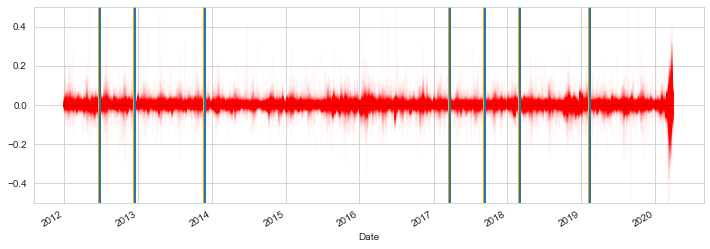

In [671]:
#orange is detection time and blue is rebalance time
plot_times(R,post_detection_times, res_times)

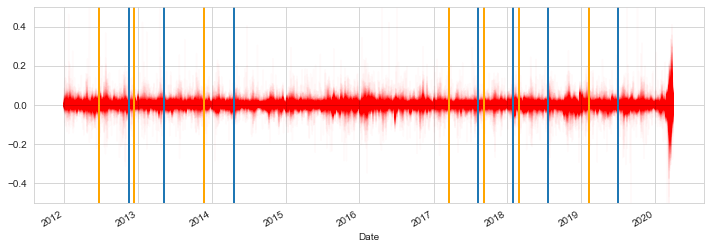

In [672]:
#orange is detectino time and blue is reblance time shifted to allow for an estimation interval. 
plot_times(R,post_detection_times_updated, res_times_updated)

### Robust mean variance implementation

In [673]:
def blanchet_mvo(R, delta_val, alpha_val):
    cov_ = R.cov()
    mean_ = np.transpose(R.mean().values)
    cov_half = la.sqrtm(cov_)
    (T, m) = R.shape
    x = cp.Variable(m)
    delta = cp.Parameter(nonneg=True)
    alpha = cp.Parameter(nonneg=True)

    delta.value = delta_val
    alpha.value = alpha_val

    constraints = [x >= 0,
                  cp.sum(x) == 1,
                  cp.sum(cp.multiply(x,mean_)) >= alpha + delta*cp.norm(x,2)]

    #objective = cp.Minimize((p1+p2)*2*cp.minimum(p1/(p1+p2),p2/(p1+p2) ))
    objective = cp.Minimize(cp.square(cp.norm(cp.matmul(cov_half, x),2) + delta*cp.norm(x,2)))

    prob = cp.Problem(objective,
                      constraints)
    return [x, prob]
#test
delta_val, alpha_val = (0.05, 0.05)
x, prob = blanchet_mvo(R, delta_val, alpha_val)